In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import linregress
import os

In [2]:
def calculate_linear_trend_spat_pattern(file_path, variable, output_file):
    #function to calculate the linear trend (slope and intercept if I want the intercept)
    #due to how slope works - need to create new data array strcutures and copy/duplicate the coordinates over
    ds = xr.open_dataset(file_path)
    
    # Extract the variable values
    ds = ds[variable]#.isel(time=slice(0,len(ds['time'])))  # Replace with the correct variable name if different
    
    # Extract time, lat, and lon
    time = ds['year'].values  # Assuming time is the dimension for time
    lat = ds['lat'].values  # Latitude values
    lon = ds['lon'].values  # Longitude values
    
    # Initialize arrays to store the regression results
    slope = np.zeros((len(lat), len(lon)))  # to store slope values for each grid point
    intercept = np.zeros((len(lat), len(lon)))  # to store intercept values for each grid point
    p_value = np.zeros((len(lat), len(lon)))
    
    # Loop over each grid point (lat, lon)
    for i in range(len(lat)):
        for j in range(len(lon)):
            # Extract the time series for each grid point - wanting to get the psl values for every grid point
            ds_series = ds[:, i, j].values  # variable values for each time point at the given lat, lon
    
            # Perform linear regression: psl ~ time
            # 'time' needs to be numeric, convert to a simple integer for linear regression. basically just list with numbers that is the length of time.
            time_numeric = np.arange(len(time))  # time as a simple integer array
            #print(time_numeric)
    
            # Perform the regression using linregress (returns slope, intercept, r_value, p_value, std_err)
            reg_slope, reg_intercept, r_value, reg_p_value, std_error = linregress(time_numeric, ds_series)
    
            # Store the results
            slope[i, j] = reg_slope
            intercept[i, j] = reg_intercept
            p_value[i, j] = reg_p_value
    
    # Create new xarray DataArrays for the slope and intercept
    slope_ds = xr.DataArray(slope, coords=[lat, lon], dims=["lat", "lon"], name="slope")
    intercept_ds = xr.DataArray(intercept, coords=[lat, lon], dims=["lat", "lon"], name="intercept")
    p_value_ds = xr.DataArray(p_value, coords=[lat, lon], dims=["lat", "lon"], name="p_value")

    # Save the results as a new netCDF file
    #slope_ds.to_netcdf(output_file, mode='w')
    #intercept_ds.to_netcdf(output_file, mode='a')

    return slope_ds, intercept_ds, p_value_ds

In [3]:
variable = 'psl'
experiment = ['historical']#,'hist-aer','hist-GHG', 'hist-sol','hist-totalO3','hist-volc']
model = ['HadGEM3-GC31-LL']
period = '1850-2015'

for e in experiment:
    print('calculating the linear trend for experiment: ', e)

    for m in model:
        print('Model: ', m)

        folder_path = '/gws/nopw/j04/extant/users/slbennie/ens_mean_spat/psl/'+e+'/'+m+'/'
        file_path = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path) if 'DJF' in filename and period in filename][0]
        output_file = '/gws/nopw/j04/extant/users/slbennie/trend_calc_LESFMIP/linear_regression/NAO/'+e+'/'+m+'/'+variable+'_mon_'+e+'_'+m+'_DJF_linear_trend_'+period+'.nc'

        slope_ds, intercept_ds, p_value_ds = calculate_linear_trend_spat_pattern(file_path, variable, output_file)

calculating the linear trend for experiment:  historical
Model:  HadGEM3-GC31-LL


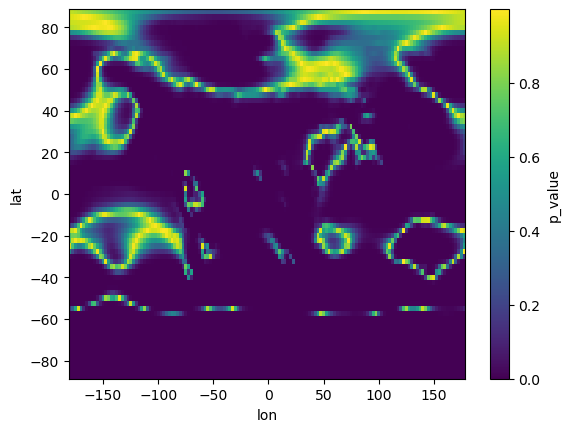

In [13]:
p_value_ds.plot()

In [23]:
# Optional: print the slope and intercept for a specific point
print(slope_ds.isel(lat=0, lon=0).values)  # Slope at the first grid point (lat=0, lon=0)
print(intercept_ds.isel(lat=0, lon=0).values)  # Intercept at the first grid point

0.5697821621786522
100112.96650996909


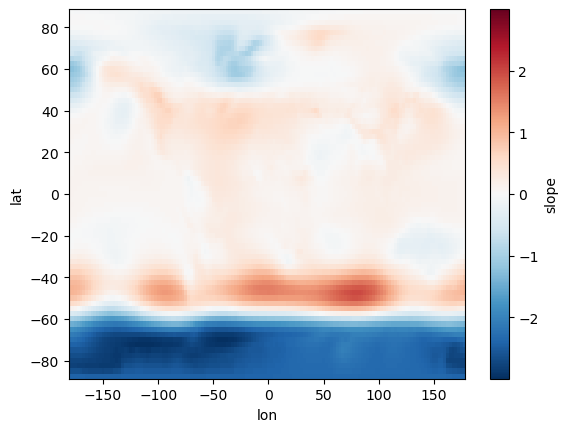

In [24]:
linear_regression = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/trend_calc_LESFMIP/linear_regression/NAO/historical/HadGEM3-GC31-LL/psl_mon_historical_HadGEM3-GC31-LL_DJF_linear_trend.nc')
#linear_regression['slope'].plot()
(linear_regression['slope']*1.45).plot()

In [25]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
def ensemble_spatial_pattern_plot_single(pressure, title, e, vmin, vmax, ax):
    # Create a figure with Cartopy projection
    pressure_plot = pressure.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm', vmin=vmin, vmax=vmax, add_colorbar=False)
    
    # Add continent outlines and other geographical features
    ax.coastlines(resolution='110m', color='black', linewidth=1)
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
    
    # Add gridlines for latitude/longitude
    ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', linestyle='--', alpha=0.6)

    # Set the title for each subplot
    ax.set_title(f'{title+e}', fontsize=24, fontweight='bold')

    return pressure_plot



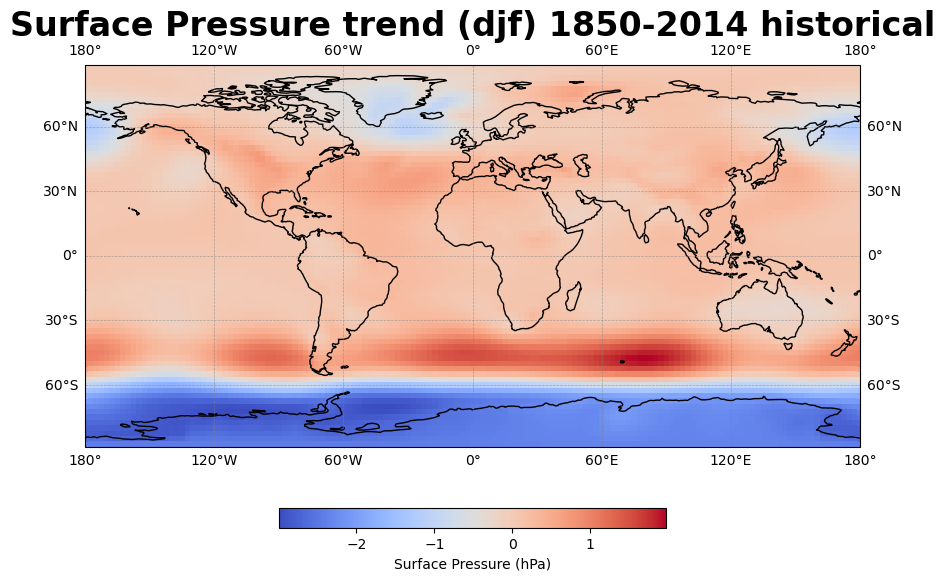

In [26]:
e = 'historical'
linear_regression_scaled = linear_regression['slope']*1.45
vmin = linear_regression_scaled.min().values
vmax = linear_regression_scaled.max().values

fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
linear_regress_spatial_pattern = ensemble_spatial_pattern_plot_single(linear_regression_scaled, 'Surface Pressure trend (djf) 1850-2014 ',e,vmin,vmax,ax)    
cbar = plt.colorbar(linear_regress_spatial_pattern, ax=ax, orientation='horizontal', pad=0.1, shrink=0.5)
cbar.set_label('Surface Pressure (hPa)')

plt.savefig('linear_regression_djf')
# Show the plot
plt.show()